# Deep Deterministic Policy Gradient

# Deep Deterministic Policy Gradient (DDPG) Algorithm

## Key Features of DDPG

1. **Actor-Critic Architecture**: DDPG uses an actor-critic method where:
   - The 'actor' determines the optimal action from states.
   - The 'critic' estimates the value of state-action pairs.

2. **Use of Deep Neural Networks**: 
   - The actor network outputs deterministic actions for given states.
   - The critic network provides a Q-value for given state-action pairs.

3. **Off-Policy Learning**: 
   - DDPG learns the optimal policy even while following a different, exploratory policy.
   - Utilizes a replay buffer to store and sample transition experiences randomly.

4. **Target Networks**: 
   - Employs target networks for both the actor and critic to stabilize learning.
   - These networks are updated less frequently to prevent rapid propagation of updates.

## How DDPG Works

The following steps outline the operation of the DDPG algorithm:

### Initialization
- Initialize the actor network $\pi(s | \theta^\pi)$ and the critic network $Q(s, a | \theta^Q)$ with their respective weights $\theta^\pi$ and $\theta^Q$.
- Initialize the target networks $\pi'(s | \theta^{\pi'})$ and $Q'(s, a | \theta^{Q'})$ with identical weights.

### Replay Buffer
- Initialize a replay buffer $\mathcal{D}$ to store tuples of (state, action, reward, next state, done flag).

### Exploration Strategy
- Implement an exploration strategy (e.g., adding noise via an Ornstein-Uhlenbeck process) to ensure the action space is sufficiently explored.

### Sampling and Learning
#### Sampling
- At each timestep, sample a mini-batch of $N$ transitions $(s, a, r, s', d)$ from the replay buffer.

#### Updating Critic
- Calculate target values using target networks:
  $$
  y_i = r_i + \gamma (1 - d_i) Q'(s'_i, \pi'(s'_i | \theta^{\pi'}))
  $$
- Update the critic by minimizing the following loss:
  $$
  L = \frac{1}{N} \sum_i (y_i - Q(s_i, a_i | \theta^Q))^2
  $$

#### Updating Actor
- Update the actor policy using the sampled policy gradient:
  $$
  \nabla_{\theta^\pi} J \approx \frac{1}{N} \sum_i \nabla_a Q(s, a | \theta^Q)|_{s=s_i, a=\pi(s_i)} \nabla_{\theta^\pi} \pi(s | \theta^\pi)|_{s_i}
  $$

### Update Target Networks
- Softly update the target networks at the end of each timestep:
  $$
  \theta^{Q'} \leftarrow \tau \theta^Q + (1 - \tau) \theta^{Q'}
  $$
  $$
  \theta^{\pi'} \leftarrow \tau \theta^\pi + (1 - \tau) \theta^{\pi'}
  $$
  where $\tau$ is a small constant (e.g., 0.001).

## Conclusion
DDPG is effective in environments with continuous action spaces and maintains stability through the use of target networks and the replay buffer. Its hybrid approach, combining deterministic policy updates (actor) with Q-value updates (critic), offers a robust framework for learning effective policies in complex scenarios.


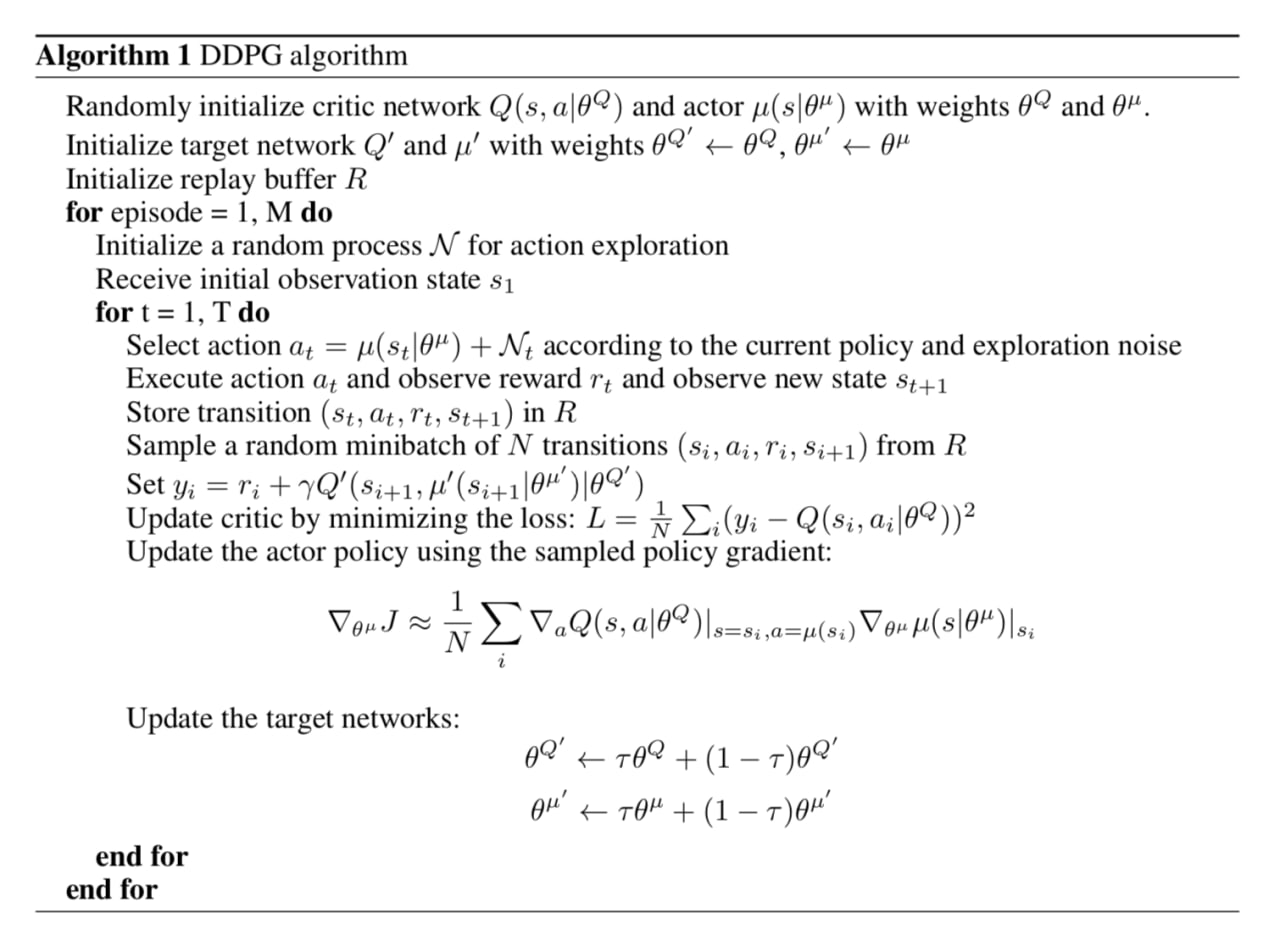

In [1]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

from dotenv import load_dotenv



load_dotenv()
print(os.getenv('DEVICE'))


None


In [2]:

# Ornstein–Uhlenbeck noise for exploration
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x

        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [3]:

class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        # takes #batchsize random idexes from 0 until maxmem
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [4]:

# Q function approximator
# says how good it was to take action A in state S
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='./models'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg.pth')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)
        # self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        # self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)

        self.q = nn.Linear(self.fc2_dims, 1)

        # compute the fan-ins for weight initialisation (see DDPG paper)
        f1 = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 0.003
        self.q.weight.data.uniform_(-f3, f3)
        self.q.bias.data.uniform_(-f3, f3)

        f4 = 1. / np.sqrt(self.action_value.weight.data.size()[0])
        self.action_value.weight.data.uniform_(-f4, f4)
        self.action_value.bias.data.uniform_(-f4, f4)

        self.optimizer = optim.Adam(self.parameters(), lr=beta,
                                    weight_decay=0.01)
        self.device = "cuda" if T.cuda.is_available() else "cpu"
#         self.device = T.device(os.environ.get('DEVICE'))

        self.to(self.device)

    # TODO: shorten this
    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        # state_value = F.relu(state_value)
        # action_value = F.relu(self.action_value(action))
        action_value = self.action_value(action)
        # TODO: understand why adding and not concatonate?
        # introduce the action values in the second hidden layer (see DDPG paper)
        state_action_value = F.relu(T.add(state_value, action_value))
        # state_action_value = T.add(state_value, action_value)
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')

        if not os.path.exists('./models'):
            os.makedirs('./models')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name + '_best.pth')
        T.save(self.state_dict(), checkpoint_file)



In [5]:

# policy approximator
# decides what action to use in current state
# OUTPUTS AN ACTION
class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='./models'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg.pth')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        # self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        # self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        # compute the fan-ins for weight initialisation (see DDPG paper)
        f2 = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f1 = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f3 = 0.003
        self.mu.weight.data.uniform_(-f3, f3)
        self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
#         self.device = T.device(os.environ.get('DEVICE'))

        self.to(self.device)

    # TODO: shorten this
    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        # we use tanh since lunar lander has action space [-1,1]
        # for other environments with different action spaces just multiply the output
        x = T.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')

        if not os.path.exists('./models'):
            os.makedirs('./models')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name + '_best.pth')
        T.save(self.state_dict(), checkpoint_file)



In [9]:

class Agent():
    def __init__(self, alpha, beta, input_dims, tau, env_id, n_actions, gamma=0.99,
                 max_size=1000000, fc1_dims=400, fc2_dims=300,
                 batch_size=64):
        self.algo = "DDPG"
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                  n_actions=n_actions, name=env_id + '_actor')
        self.critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                    n_actions=n_actions, name=env_id + '_critic')

        self.target_actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                         n_actions=n_actions, name=env_id + '_target_actor')

        self.target_critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                           n_actions=n_actions, name=env_id + '_target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        # add noise
        mu_prime = mu + T.tensor(self.noise(),
                                 dtype=T.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return None, None

        states, actions, rewards, states_, done = \
            self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions)
        critic_value = self.critic.forward(states, actions)

        # set Q value of terminal states to 0 (since there will be no future reward)
        critic_value_[done] = 0.0
        # make a list of all critic values (previously it was list of lists)
        critic_value_ = critic_value_.view(-1)

        # y =  r + Q'( s(i+1), U'(s(i+1))
        # --> target = reward + The Q-value (given by target critic) of the action (given by target actor)
        # of the new state
        target = rewards + self.gamma * critic_value_
        # add batch dimension
        target = target.view(self.batch_size, 1)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        # actor loss : mean of the gradient of the Q value of the action the actor would take
        # minus because gradient ASCENT
        actor_loss = -self.critic.forward(states, self.actor.forward(states))
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        # soft update the target networks in direction of current networks
        self.update_network_parameters()

        return actor_loss.cpu().detach().numpy(), critic_loss.cpu().detach().numpy()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau * critic_state_dict[name].clone() + \
                                      (1 - tau) * target_critic_state_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau * actor_state_dict[name].clone() + \
                                     (1 - tau) * target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)
        # for batchnorm:
        # self.target_critic.load_state_dict(critic_state_dict, strict=False)
        # self.target_actor.load_state_dict(actor_state_dict, strict=False)


In [10]:


def simple_plot(scores, mean_scores, epoch):
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    # plt.ylim(ymin=0)
    plt.text(len(scores) - 1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores) - 1, mean_scores[-1], str(mean_scores[-1]))
    if epoch % 10 == 0:
        plt.show()


def plot_learning_curve(x, scores, figure_file, algo, env_id):

    if not os.path.exists('./plots'):
        os.makedirs('./plots')

    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i - 100):(i + 1)])
    plt.plot(x, running_avg)
    plt.title(f'{algo} {env_id} avg 100 scores')
    plt.savefig(figure_file)
    plt.close()


In [13]:

# Hyperparams
n_games = 800
load_checkpoint = False
iterations = 1

env_id = 'LunarLanderContinuous-v2'

env = gym.make(env_id)

all_rewards = []
all_actor_losses = []
all_critic_losses = []
all_trajectory_lengths = []


def train(iteration):
    filename = agent.algo + "_" + env_id + "_" + str(n_games) + "games" + "_" + str(iteration) + '.png'
    figure_file = 'plots/' + filename

    best_score = env.reward_range[0]
    score_history = []

    if load_checkpoint:
        agent.load_models()
        if os.environ.get('RENDER') == "t":
            env.render(mode='human')

    steps = 0
    for i in range(n_games):
        observation, _ = env.reset()
        done = False
        score = 0

        count = 0
        a_losses = []
        c_losses = []

        # for every episode:
        while not done:
            if os.environ.get('RENDER') == "t":
                env.render()

            action = agent.choose_action(observation)
            observation_, reward, done, _,  info = env.step(action[0])
            count += 1
            steps += 1
            agent.remember(observation, action, reward, observation_, done)
            if not load_checkpoint:
                actor_loss, critic_loss = agent.learn()
                if actor_loss is not None:
                    a_losses.append(actor_loss)
                    c_losses.append(critic_loss)
            score += reward
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        all_rewards.append(score)
        all_trajectory_lengths.append(count)
        all_actor_losses.append(np.mean(a_losses))
        all_critic_losses.append(np.mean(c_losses))

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print(env_id, "|", 'episode', i, "|", 'score %.1f' % score, "|",
              '100 games avg %.1f' % avg_score, "|",
              'steps %d' % steps, "|"
              )

    if not load_checkpoint:
        x = [i + 1 for i in range(n_games)]
        plot_learning_curve(x, score_history, figure_file, agent.algo, env_id)


for iteration in range(iterations):
    agent = Agent(alpha=0.0001, beta=0.001,
                    input_dims=env.observation_space.shape, tau=0.001, env_id=env_id,
                    batch_size=64, fc1_dims=400, fc2_dims=300,
                    n_actions=env.action_space.shape[0])
    train(iteration + 1)


... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 0 | score -394.9 | 100 games avg -394.9 | steps 157 |
LunarLanderContinuous-v2 | episode 1 | score -563.3 | 100 games avg -479.1 | steps 226 |
LunarLanderContinuous-v2 | episode 2 | score -903.4 | 100 games avg -620.5 | steps 313 |
LunarLanderContinuous-v2 | episode 3 | score -417.2 | 100 games avg -569.7 | steps 408 |
LunarLanderContinuous-v2 | episode 4 | score -677.8 | 100 games avg -591.3 | steps 466 |
LunarLanderContinuous-v2 | episode 5 | score -1222.3 | 100 games avg -696.5 | steps 574 |
LunarLanderContinuous-v2 | episode 6 | score -870.2 | 100 games avg -721.3 | steps 659 |
LunarLanderContinuous-v2 | episode 7 | score -676.5 | 100 games avg -715.7 | steps 718 |
LunarLanderContinuous-v2 | episode 8 | score -1019.3 | 100 games avg -749.4 | steps 819 |
LunarLanderContinuous-v2 | episode 9 | score -909.3 | 100 games avg -765.4 | steps 896 |
Luna

LunarLanderContinuous-v2 | episode 89 | score -266.8 | 100 games avg -478.7 | steps 29855 |
LunarLanderContinuous-v2 | episode 90 | score -459.2 | 100 games avg -478.5 | steps 29988 |
LunarLanderContinuous-v2 | episode 91 | score -256.1 | 100 games avg -476.1 | steps 30277 |
LunarLanderContinuous-v2 | episode 92 | score -485.8 | 100 games avg -476.2 | steps 30415 |
LunarLanderContinuous-v2 | episode 93 | score -99.5 | 100 games avg -472.1 | steps 31117 |
LunarLanderContinuous-v2 | episode 94 | score -237.5 | 100 games avg -469.7 | steps 32071 |
LunarLanderContinuous-v2 | episode 95 | score -425.4 | 100 games avg -469.2 | steps 34222 |
LunarLanderContinuous-v2 | episode 96 | score -416.5 | 100 games avg -468.7 | steps 36027 |
LunarLanderContinuous-v2 | episode 97 | score -187.7 | 100 games avg -465.8 | steps 36567 |
LunarLanderContinuous-v2 | episode 98 | score -177.5 | 100 games avg -462.9 | steps 37334 |
LunarLanderContinuous-v2 | episode 99 | score -185.2 | 100 games avg -460.1 | ste

... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 144 | score -135.9 | 100 games avg -287.3 | steps 75432 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 145 | score -51.4 | 100 games avg -282.0 | steps 75636 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 146 | score -9.8 | 100 games avg -274.5 | steps 75818 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 147 | score -285.2 | 100 games avg -271.5 | steps 76092 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 148 | score -160.3 | 100 games avg -268.1 | steps 76269 |
... saving checkpo

LunarLanderContinuous-v2 | episode 201 | score 31.0 | 100 games avg -250.7 | steps 118080 |
LunarLanderContinuous-v2 | episode 202 | score -517.2 | 100 games avg -254.2 | steps 120105 |
LunarLanderContinuous-v2 | episode 203 | score -289.2 | 100 games avg -256.1 | steps 123440 |
LunarLanderContinuous-v2 | episode 204 | score -101.8 | 100 games avg -255.2 | steps 125374 |
LunarLanderContinuous-v2 | episode 205 | score -1011.7 | 100 games avg -263.4 | steps 132599 |
LunarLanderContinuous-v2 | episode 206 | score 161.6 | 100 games avg -260.2 | steps 133398 |
LunarLanderContinuous-v2 | episode 207 | score -593.5 | 100 games avg -264.1 | steps 136588 |
LunarLanderContinuous-v2 | episode 208 | score -204.9 | 100 games avg -263.9 | steps 136714 |
LunarLanderContinuous-v2 | episode 209 | score 114.5 | 100 games avg -260.6 | steps 137839 |
LunarLanderContinuous-v2 | episode 210 | score 124.9 | 100 games avg -256.8 | steps 138736 |
LunarLanderContinuous-v2 | episode 211 | score 112.9 | 100 games

LunarLanderContinuous-v2 | episode 261 | score -849.4 | 100 games avg -142.2 | steps 190352 |
LunarLanderContinuous-v2 | episode 262 | score -149.1 | 100 games avg -142.2 | steps 191361 |
LunarLanderContinuous-v2 | episode 263 | score 103.5 | 100 games avg -138.4 | steps 192216 |
LunarLanderContinuous-v2 | episode 264 | score 147.7 | 100 games avg -137.8 | steps 193360 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 265 | score 44.7 | 100 games avg -135.4 | steps 194667 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 266 | score 44.3 | 100 games avg -131.9 | steps 195799 |
LunarLanderContinuous-v2 | episode 267 | score -619.9 | 100 games avg -139.1 | steps 198353 |
LunarLanderContinuous-v2 | episode 268 | score -157.5 | 100 games avg -138.0 | steps 200677 |
LunarLanderContinuous-v2 | episode 269 | score

LunarLanderContinuous-v2 | episode 327 | score -231.4 | 100 games avg -60.4 | steps 286519 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 328 | score 191.1 | 100 games avg -57.3 | steps 287152 |
LunarLanderContinuous-v2 | episode 329 | score -339.9 | 100 games avg -57.4 | steps 287446 |
LunarLanderContinuous-v2 | episode 330 | score -315.9 | 100 games avg -59.1 | steps 287534 |
LunarLanderContinuous-v2 | episode 331 | score -588.3 | 100 games avg -67.5 | steps 287649 |
LunarLanderContinuous-v2 | episode 332 | score -384.1 | 100 games avg -69.4 | steps 287766 |
LunarLanderContinuous-v2 | episode 333 | score 24.2 | 100 games avg -63.4 | steps 288015 |
LunarLanderContinuous-v2 | episode 334 | score 172.5 | 100 games avg -60.0 | steps 288649 |
LunarLanderContinuous-v2 | episode 335 | score -229.2 | 100 games avg -60.8 | steps 288791 |
LunarLanderContinuous-v2 | episode 336 | score -196.0 | 100 gam

... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 379 | score 231.9 | 100 games avg 57.9 | steps 312947 |
LunarLanderContinuous-v2 | episode 380 | score -29.6 | 100 games avg 55.6 | steps 313299 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 381 | score 1.1 | 100 games avg 66.2 | steps 313728 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 382 | score 261.7 | 100 games avg 70.9 | steps 314084 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 383 | score -30.1 | 100 games avg 77.8 | steps 314599 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | 

LunarLanderContinuous-v2 | episode 449 | score 204.1 | 100 games avg 116.3 | steps 349354 |
LunarLanderContinuous-v2 | episode 450 | score 274.7 | 100 games avg 117.0 | steps 349643 |
LunarLanderContinuous-v2 | episode 451 | score 276.5 | 100 games avg 117.5 | steps 349948 |
LunarLanderContinuous-v2 | episode 452 | score 146.6 | 100 games avg 116.9 | steps 350561 |
LunarLanderContinuous-v2 | episode 453 | score 144.5 | 100 games avg 115.5 | steps 351416 |
LunarLanderContinuous-v2 | episode 454 | score 238.7 | 100 games avg 115.2 | steps 351843 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 455 | score 273.2 | 100 games avg 120.5 | steps 352140 |
LunarLanderContinuous-v2 | episode 456 | score -15.1 | 100 games avg 117.7 | steps 352348 |
LunarLanderContinuous-v2 | episode 457 | score 164.3 | 100 games avg 118.5 | steps 353095 |
LunarLanderContinuous-v2 | episode 458 | score 49.9 | 100 games avg 

LunarLanderContinuous-v2 | episode 514 | score 243.4 | 100 games avg 167.9 | steps 377090 |
LunarLanderContinuous-v2 | episode 515 | score 252.0 | 100 games avg 168.5 | steps 377330 |
LunarLanderContinuous-v2 | episode 516 | score -10.2 | 100 games avg 168.7 | steps 377534 |
LunarLanderContinuous-v2 | episode 517 | score 37.4 | 100 games avg 166.9 | steps 377714 |
LunarLanderContinuous-v2 | episode 518 | score -223.7 | 100 games avg 162.9 | steps 377973 |
LunarLanderContinuous-v2 | episode 519 | score 208.4 | 100 games avg 163.3 | steps 378313 |
LunarLanderContinuous-v2 | episode 520 | score 258.3 | 100 games avg 164.1 | steps 378754 |
LunarLanderContinuous-v2 | episode 521 | score 198.8 | 100 games avg 164.7 | steps 379153 |
LunarLanderContinuous-v2 | episode 522 | score 254.7 | 100 games avg 169.3 | steps 379502 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 523 | score 221.2 | 100 games avg

LunarLanderContinuous-v2 | episode 586 | score 248.4 | 100 games avg 173.2 | steps 401196 |
LunarLanderContinuous-v2 | episode 587 | score 236.2 | 100 games avg 173.3 | steps 401454 |
LunarLanderContinuous-v2 | episode 588 | score 262.8 | 100 games avg 173.5 | steps 401669 |
LunarLanderContinuous-v2 | episode 589 | score 232.5 | 100 games avg 181.3 | steps 401972 |
LunarLanderContinuous-v2 | episode 590 | score 250.8 | 100 games avg 187.7 | steps 402242 |
LunarLanderContinuous-v2 | episode 591 | score 283.2 | 100 games avg 188.2 | steps 402574 |
LunarLanderContinuous-v2 | episode 592 | score 252.7 | 100 games avg 188.3 | steps 402816 |
LunarLanderContinuous-v2 | episode 593 | score -19.6 | 100 games avg 185.8 | steps 403092 |
LunarLanderContinuous-v2 | episode 594 | score 250.5 | 100 games avg 185.9 | steps 403372 |
LunarLanderContinuous-v2 | episode 595 | score 262.8 | 100 games avg 186.2 | steps 403630 |
LunarLanderContinuous-v2 | episode 596 | score 233.7 | 100 games avg 186.5 | ste

LunarLanderContinuous-v2 | episode 675 | score 195.4 | 100 games avg 167.9 | steps 432802 |
LunarLanderContinuous-v2 | episode 676 | score 181.6 | 100 games avg 167.6 | steps 433291 |
LunarLanderContinuous-v2 | episode 677 | score 193.6 | 100 games avg 168.0 | steps 433582 |
LunarLanderContinuous-v2 | episode 678 | score 279.6 | 100 games avg 170.5 | steps 433864 |
LunarLanderContinuous-v2 | episode 679 | score -887.3 | 100 games avg 159.2 | steps 440733 |
LunarLanderContinuous-v2 | episode 680 | score 265.7 | 100 games avg 161.8 | steps 441053 |
LunarLanderContinuous-v2 | episode 681 | score 297.4 | 100 games avg 162.4 | steps 441385 |
LunarLanderContinuous-v2 | episode 682 | score -207.4 | 100 games avg 157.2 | steps 441700 |
LunarLanderContinuous-v2 | episode 683 | score -3.4 | 100 games avg 155.1 | steps 443196 |
LunarLanderContinuous-v2 | episode 684 | score 257.2 | 100 games avg 157.9 | steps 443474 |
LunarLanderContinuous-v2 | episode 685 | score 284.7 | 100 games avg 158.3 | st

LunarLanderContinuous-v2 | episode 765 | score 254.3 | 100 games avg 90.7 | steps 492547 |
LunarLanderContinuous-v2 | episode 766 | score 185.7 | 100 games avg 90.6 | steps 493041 |
LunarLanderContinuous-v2 | episode 767 | score 0.7 | 100 games avg 88.8 | steps 493307 |
LunarLanderContinuous-v2 | episode 768 | score 209.9 | 100 games avg 88.2 | steps 493889 |
LunarLanderContinuous-v2 | episode 769 | score -135.3 | 100 games avg 84.0 | steps 494315 |
LunarLanderContinuous-v2 | episode 770 | score 240.6 | 100 games avg 83.9 | steps 494608 |
LunarLanderContinuous-v2 | episode 771 | score 220.4 | 100 games avg 89.1 | steps 494862 |
LunarLanderContinuous-v2 | episode 772 | score 266.6 | 100 games avg 94.1 | steps 495403 |
LunarLanderContinuous-v2 | episode 773 | score 189.1 | 100 games avg 94.1 | steps 496343 |
LunarLanderContinuous-v2 | episode 774 | score 193.0 | 100 games avg 93.3 | steps 496571 |
LunarLanderContinuous-v2 | episode 775 | score 220.0 | 100 games avg 93.6 | steps 496875 |


In [14]:
import pandas as pd

all_results = {
    "rewards": all_rewards,
    "actor_losses": all_actor_losses,
    "critic_losses": all_critic_losses,
    "trajectory_lengths": all_trajectory_lengths
}

df = pd.DataFrame(all_results)
df.to_csv('results.csv')

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


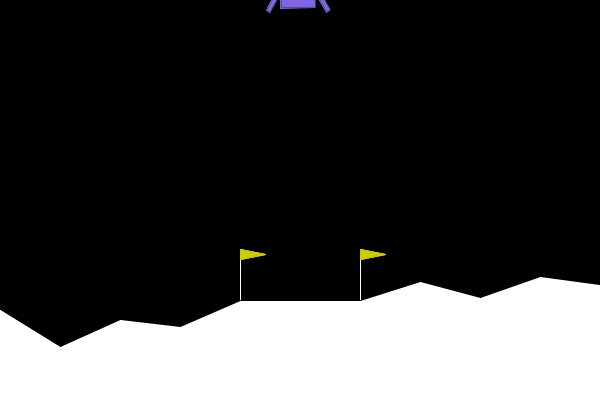

In [15]:
from IPython.display import Image as IImage
from PIL import Image


def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)
    
    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        with T.no_grad():
            action = agent.choose_action(obs)
            
        obs, _, terminated, truncated, _ = env.step(action[0])
        render_res  = env.render()
        imgs.append(render_res)
        
        if terminated or truncated:
            break

    return imgs

agent = Agent(alpha=0.0001, beta=0.001,
                    input_dims=env.observation_space.shape, tau=0.001, env_id=env_id,
                    batch_size=64, fc1_dims=400, fc2_dims=300,
                    n_actions=env.action_space.shape[0])

env = gym.make(env_id, render_mode="rgb_array")
agent.load_models()
imgs = rendered_rollout(agent.actor, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")

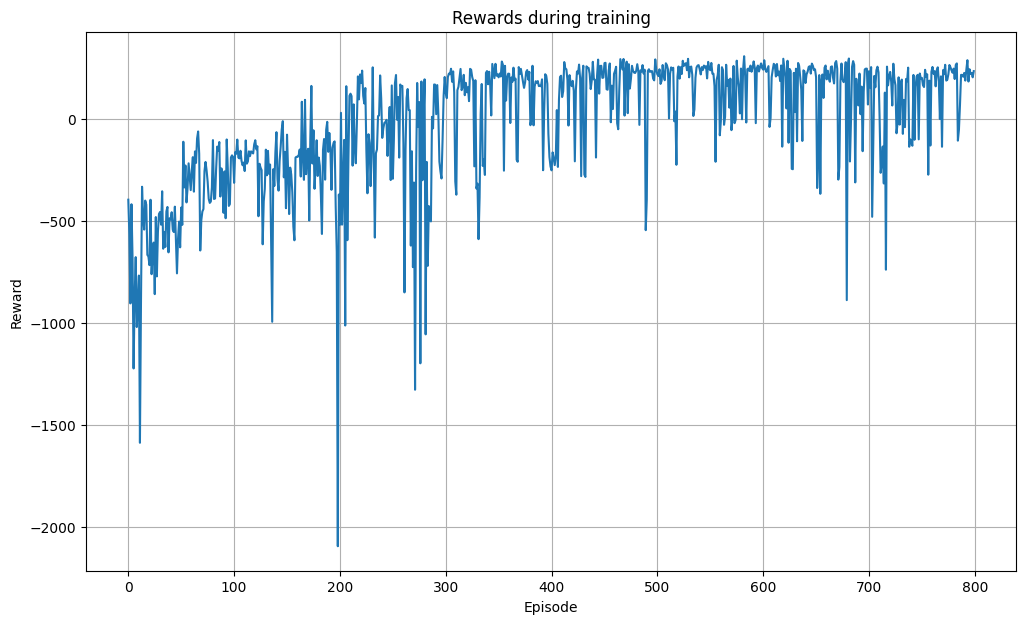

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.plot(all_rewards)
plt.title("Rewards during training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.savefig("single_rewards.png")

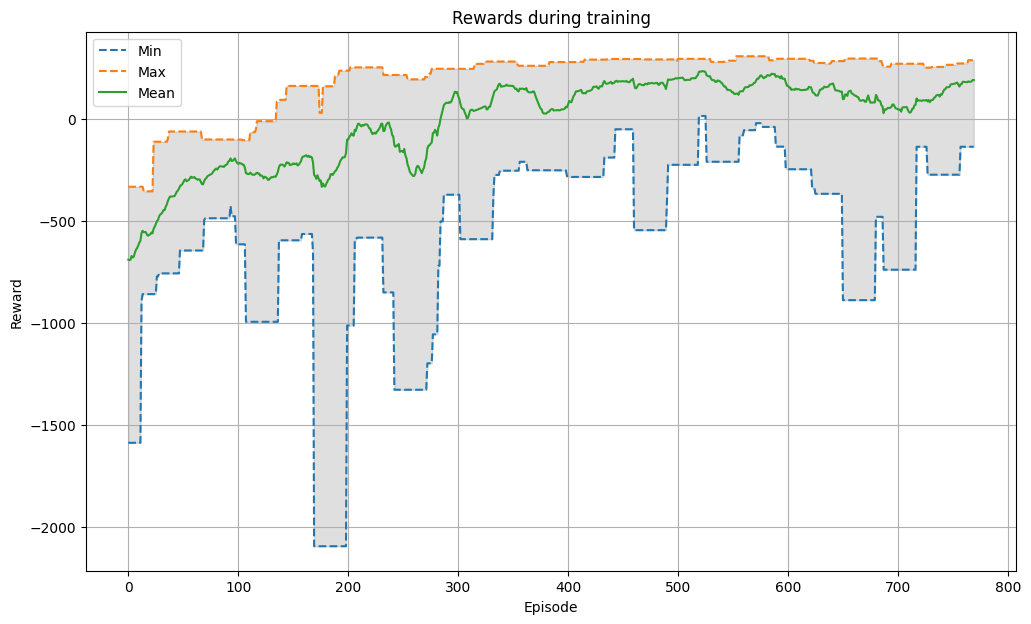

In [34]:
interval = 100
min_r = [min(all_rewards[i:i+interval]) for i in range(len(all_rewards)-interval)]
max_r = [max(all_rewards[i:i+interval]) for i in range(len(all_rewards)-interval)]
plt.figure(figsize=(12, 7))
plt.plot(min_r, label="Min", linestyle='--')
plt.plot(max_r, label="Max", linestyle='--')
plt.plot([np.mean(all_rewards[i:i+interval]) for i in range(len(all_rewards)-interval)], label="Mean")
plt.legend()
plt.fill_between(range(len(all_rewards)-interval), min_r, max_r, color='gray', alpha=0.25)
plt.title("Rewards during training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.savefig('aggregated_rewards.png')

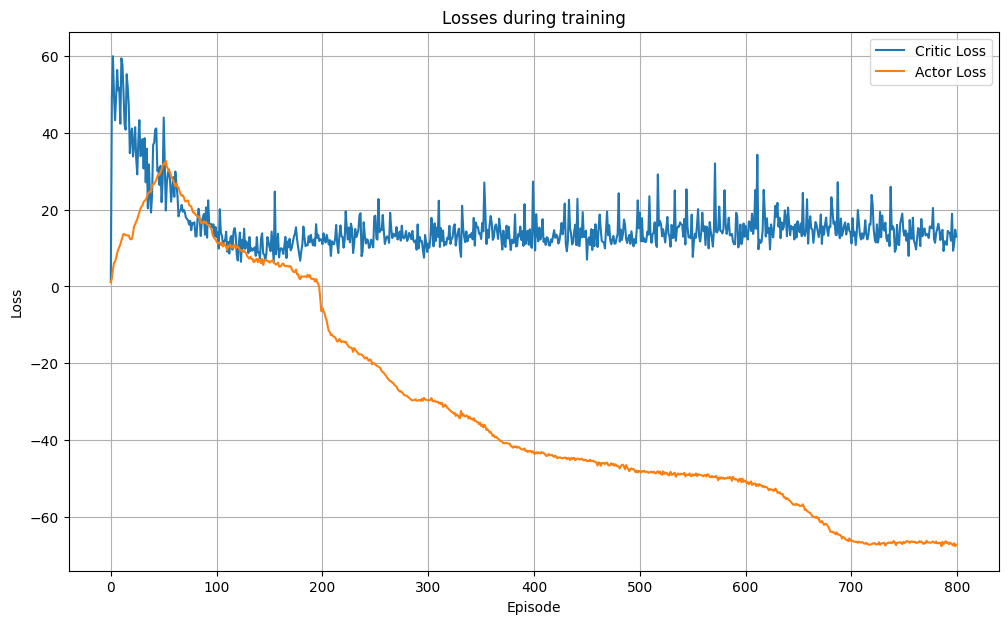

In [35]:

plt.figure(figsize=(12, 7))
plt.plot(all_critic_losses, label="Critic Loss")
plt.plot(all_actor_losses, label="Actor Loss")
plt.legend()
plt.title("Losses during training")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid()
plt.savefig("losses.png")

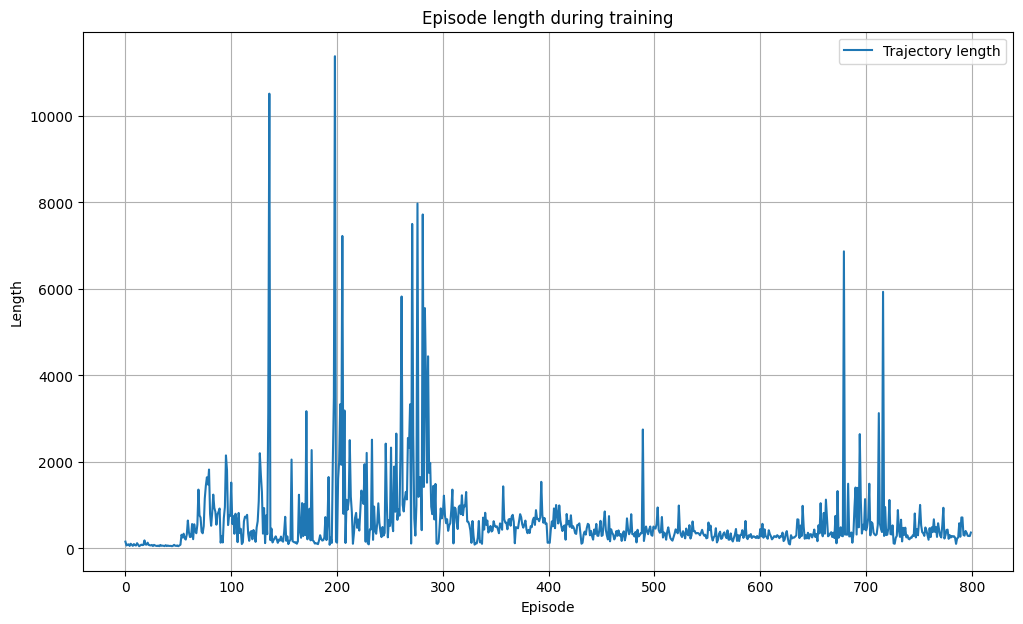

In [37]:
plt.figure(figsize=(12, 7))
plt.plot(all_trajectory_lengths, label="Trajectory length")
plt.legend()
plt.title("Episode length during training")
plt.xlabel("Episode")
plt.ylabel("Length")
plt.grid()
plt.savefig("episode_length.png")